In [ ]:
"""
notebook: 1.5.-leibold-data-modeling_shapValueAnalysis.jpynb

author: Christian Leibold

created/updated at: 2025-12-11

intention: SHAP analysis saved SHAP values. Including AGGREGATION OF SHAP values. 

content:
---------
-> load saved shap values from random forest model with over-/undersampling
-> create different shap plots
-> aggregate shap values and use plots on them 

"""

In [1]:
# classic packages
import pandas as pd
import numpy as np
from joblib import dump, load

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# make custom libraries importable
import sys
sys.path.append('../../library')

# evaluation
import shap

# little helper
import time


In [2]:
# ------------------------------------------------------------------------------- 
# loading saved shap values
# -------------------------------------------------------------------------------
# load data 
shap_values = load('../../models/shap_values_rf_multiclass_final.joblib')

# store feature_names in object + make a list object for indexing later
feature_names = shap_values.feature_names
feature_names_list = list(feature_names)


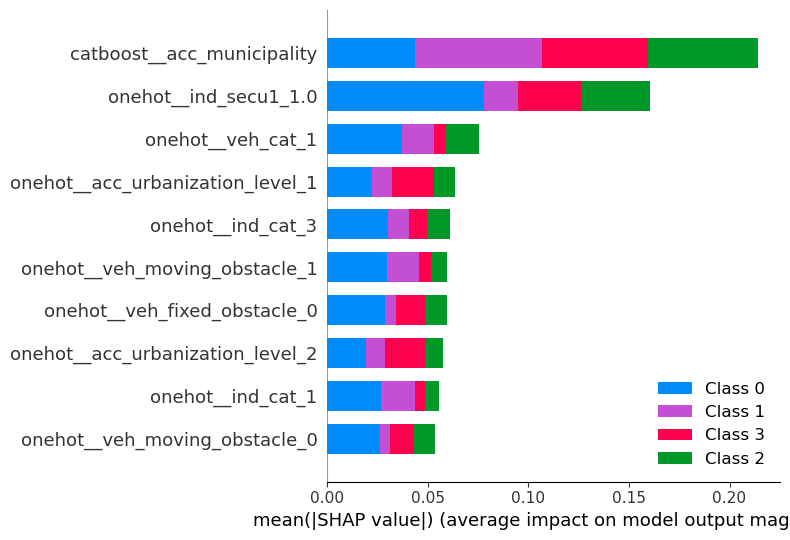

In [17]:
# ------------------------------------------------------------------------------- 
# global feature importance on prediction
# -------------------------------------------------------------------------------
shap.summary_plot(shap_values.values[:, :, :], shap_values.data, feature_names=feature_names, plot_type= 'bar', max_display=10)


In [33]:
# ------------------------------------------------------------------------------- 
# force plot to insprect single rows -> still does not work at the moment
# -------------------------------------------------------------------------------
shap.initjs()

row_idx = 1234
class_idx = 3

# Correct slicing
base_val   = shap_values.base_values[row_idx, class_idx]   # base value for this row/class
shap_val   = shap_values.values[row_idx, :, class_idx]     # SHAP values for this row/class
features   = shap_values.data[row_idx]                     # feature values for this row

# Force plot
shap.force_plot(
    base_val,
    shap_val,
    features,
    feature_names=shap_values.feature_names
)

In [44]:
# ------------------------------------------------------------------------------- 
# force plot for all classes to insprect single rows -> still does not work at the moment
# -------------------------------------------------------------------------------
shap.initjs()

row_idx = 1234   # the row you want to explain
n_classes = shap_values.values.shape[2]   # number of classes (here 4)

# Loop through each class
for class_idx in range(n_classes):
    base_val   = shap_values.base_values[row_idx, class_idx]
    shap_val   = shap_values.values[row_idx, :, class_idx]
    features   = shap_values.data[row_idx]

    # Display force plot for this class
    display(shap.force_plot(
        base_val,
        shap_val,
        features,
        feature_names=shap_values.feature_names,
        #matplotlib=True   # optional: ensures inline rendering in notebooks
        #link='logit'

    ))

Summary plot for class 0


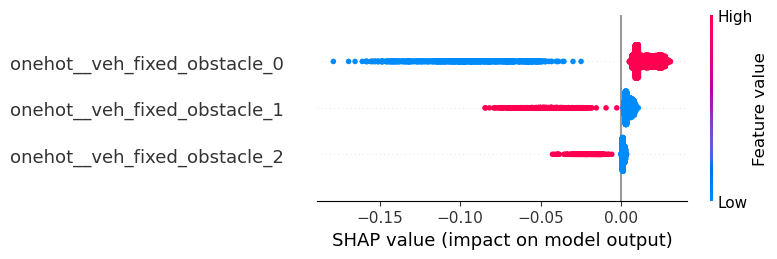

Summary plot for class 1


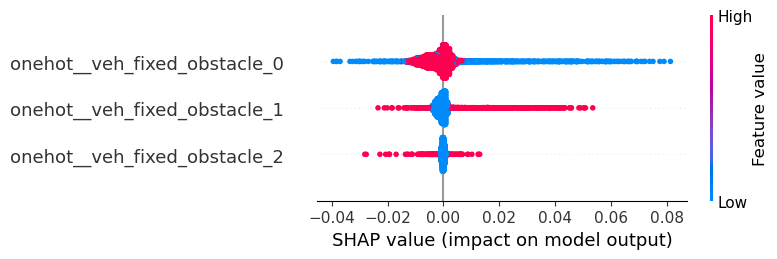

Summary plot for class 2


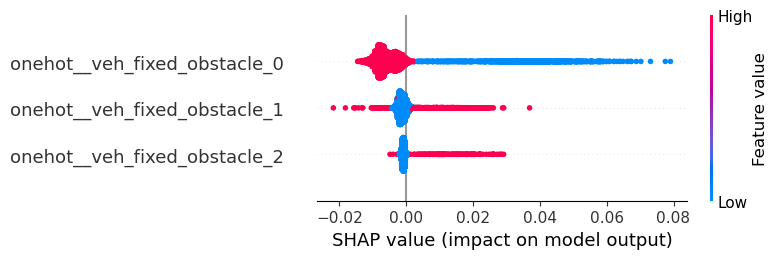

Summary plot for class 3


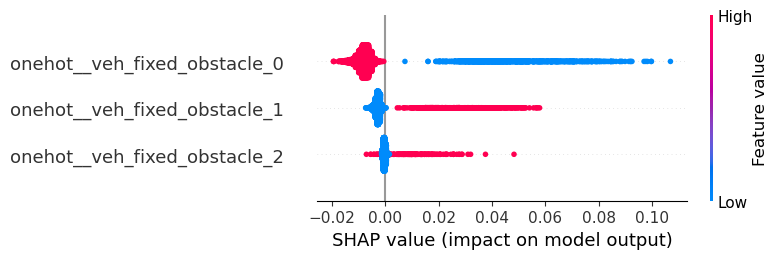

In [11]:
# ------------------------------------------------------------------------------- 
# beeswarm plot looped over all classes with subset of features
# -------------------------------------------------------------------------------
# Filter names that start with the prefix
prefix = "onehot__veh_fixed_obstacle"
#prefix = "cyclical__"
selected_features = [f for f in feature_names_list if f.startswith(prefix)]

# Get indices of the selected features
selected_idx = [feature_names_list.index(f) for f in selected_features]

# Iterate over classes
for c in range(shap_values.values.shape[-1]):  
    # Slice SHAP values for class c and selected features
    shap_subset = shap_values.values[:, selected_idx, c]
    
    # Slice corresponding feature data directly from shap_values.data
    X_subset = shap_values.data[:, selected_idx]
    
    print(f"Summary plot for class {c}")
    shap.summary_plot(
        shap_subset,
        features=X_subset,
        feature_names=selected_features,
        max_display=len(selected_features)
    )


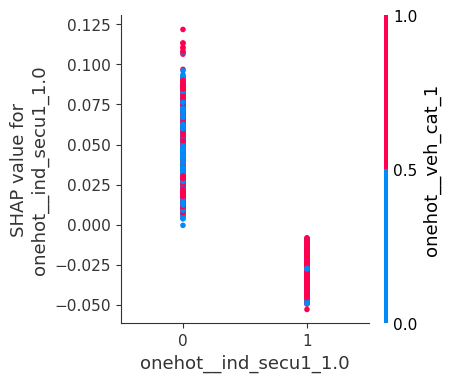

In [37]:
# ------------------------------------------------------------------------------- 
# dependence plot
# -------------------------------------------------------------------------------
shap.dependence_plot(
    "onehot__ind_secu1_1.0",
    shap_values.values[:, :, 3],
    shap_values.data,
    feature_names=shap_values.feature_names,
    interaction_index="onehot__veh_cat_1",     # if no interaction_index is given, the most related feature will be chosen
    show=False
)

ax = plt.gca()
ax.set_xticks([0, 1])
ax.set_xlim(-0.5, 1.5)   # tighten around 0 and 1
plt.gcf().set_size_inches(4, 4)  # shrink width (default is ~8)
plt.show()

In [48]:
# ------------------------------------------------------------------------------- 
# class for aggregation of onehot/cyclical encoded features
# -------------------------------------------------------------------------------
class ShapOneHotAggregator:
    """
    Aggregate SHAP values of one-hot and cyclical encoded features back to their original feature.
    """

    def __init__(self, feature_names, prefix="onehot__", cyclical_prefix="cyclical__"):
        self.feature_names = feature_names
        self.prefix = prefix
        self.cyclical_prefix = cyclical_prefix
        self.groups = self._build_groups()

    def _build_groups(self):
        groups = {}
        for fname in self.feature_names:
            if fname.startswith(self.prefix):
                # One-hot encoded
                base = fname[len(self.prefix):]
                parent = base.rsplit("_", 1)[0]
                groups.setdefault(parent, []).append(fname)
            elif fname.startswith(self.cyclical_prefix):
                # Cyclical encoded (_sin/_cos)
                parent = fname.rsplit("_", 1)[0]  # remove _sin/_cos
                groups.setdefault(parent, []).append(fname)
            else:
                # Continuous or already atomic
                groups.setdefault(fname, [fname])
        return groups

    def aggregate(self, shap_values, data, base_values=None):
        has_classes = shap_values.ndim == 3
        agg_list, agg_feature_names = [], []

        for parent, children in self.groups.items():
            idxs = [self.feature_names.index(ch) for ch in children]
            if has_classes:
                agg_vals = shap_values[:, idxs, :].sum(axis=1)
            else:
                agg_vals = shap_values[:, idxs].sum(axis=1)
            agg_list.append(agg_vals)
            agg_feature_names.append(parent)

        agg_values = np.stack(agg_list, axis=1) if has_classes else np.column_stack(agg_list)

        # Collapse data
        X_df = pd.DataFrame(data, columns=self.feature_names)
        agg_data = pd.DataFrame(index=X_df.index)
        for parent, children in self.groups.items():
            if parent.startswith("cyclical__") and len(children) == 2:
                # Keep both sin/cos values but collapse into one parent vector
                agg_data[parent] = np.sqrt(X_df[children[0]]**2 + X_df[children[1]]**2)
            elif len(children) > 1 and children[0].startswith(self.prefix):
                # One-hot collapse
                agg_data[parent] = X_df[children].idxmax(axis=1).str.replace(f"{parent}_", "")
            else:
                agg_data[parent] = X_df[children[0]]

        explainer_agg = shap.Explanation(
            values=agg_values,
            base_values=base_values,
            data=agg_data.values,
            feature_names=agg_feature_names
        )
        return explainer_agg, self.groups

In [40]:
# ------------------------------------------------------------------------------- 
# aggregation of onehot/cyclical encoded features
# -------------------------------------------------------------------------------
aggregator = ShapOneHotAggregator(feature_names_list)
explainer_agg, mapping = aggregator.aggregate(shap_values.values, shap_values.data)

# Now explainer_agg.values and explainer_agg.data have matching shapes
print(explainer_agg.values.shape)  # (n_samples, n_features_new, n_classes)
print(explainer_agg.data.shape)    # (n_samples, n_features_new)



(5000, 17, 4)
(5000, 17)


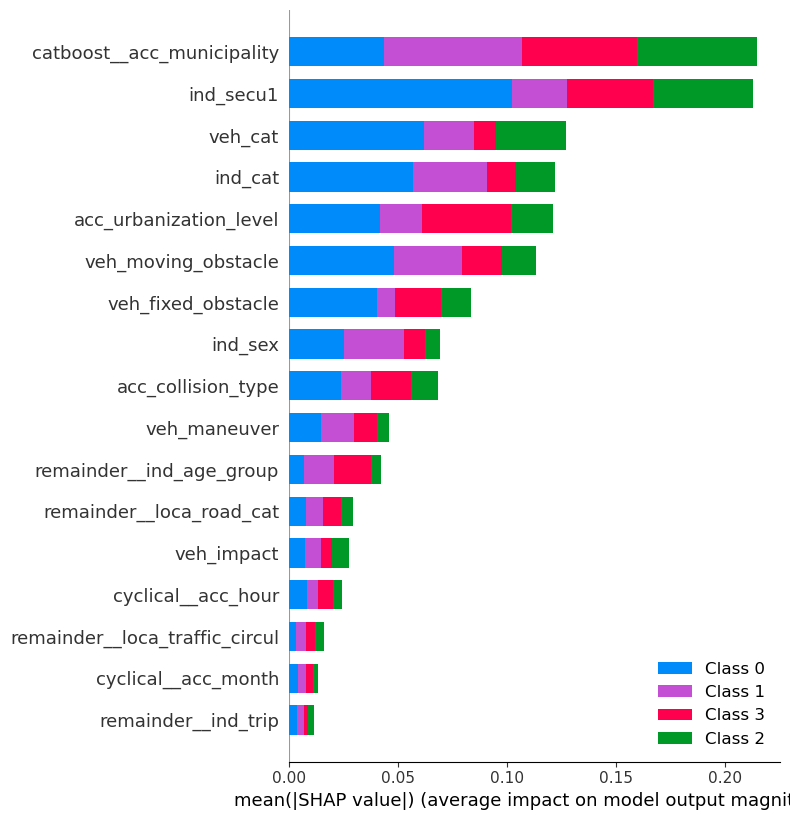

In [49]:
# ------------------------------------------------------------------------------- 
# summary plot with aggregated features for golobal impact on prediction
# -------------------------------------------------------------------------------
shap.summary_plot(
    explainer_agg.values,
    explainer_agg.data,
    feature_names=explainer_agg.feature_names,
    plot_type="bar",
    max_display=20
)

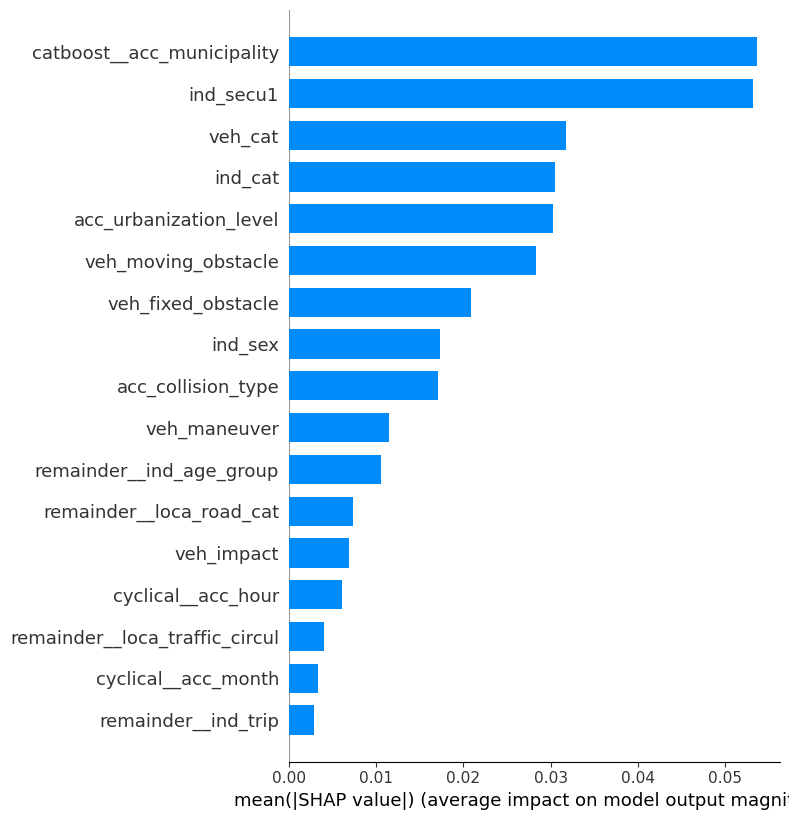

In [42]:
# ------------------------------------------------------------------------------- 
# mean shap value per aggregated feature (same as obove without class separation)
# -------------------------------------------------------------------------------
mean_abs = np.abs(explainer_agg.values).mean(axis=(0, 2))
shap.summary_plot(
    mean_abs.reshape(1, -1),  # fake sample dimension
    feature_names=explainer_agg.feature_names,
    plot_type="bar"
)


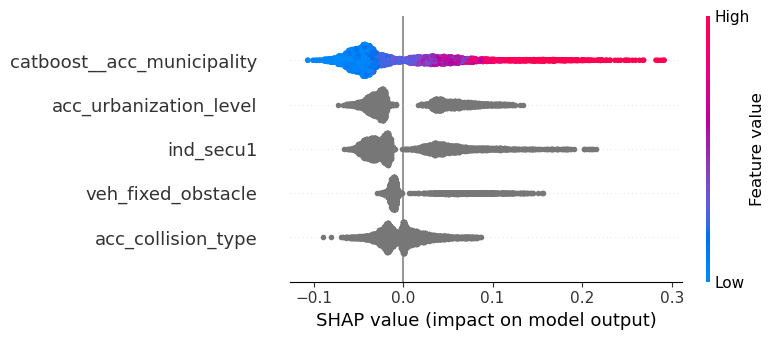

In [44]:
# ------------------------------------------------------------------------------- 
# beeswarm plot with aggregated features 
# -------------------------------------------------------------------------------
shap.summary_plot(
    explainer_agg.values[:, :, 3],   # take class 0
    explainer_agg.data,
    feature_names=explainer_agg.feature_names,
    plot_type="dot",
    max_display=5
)


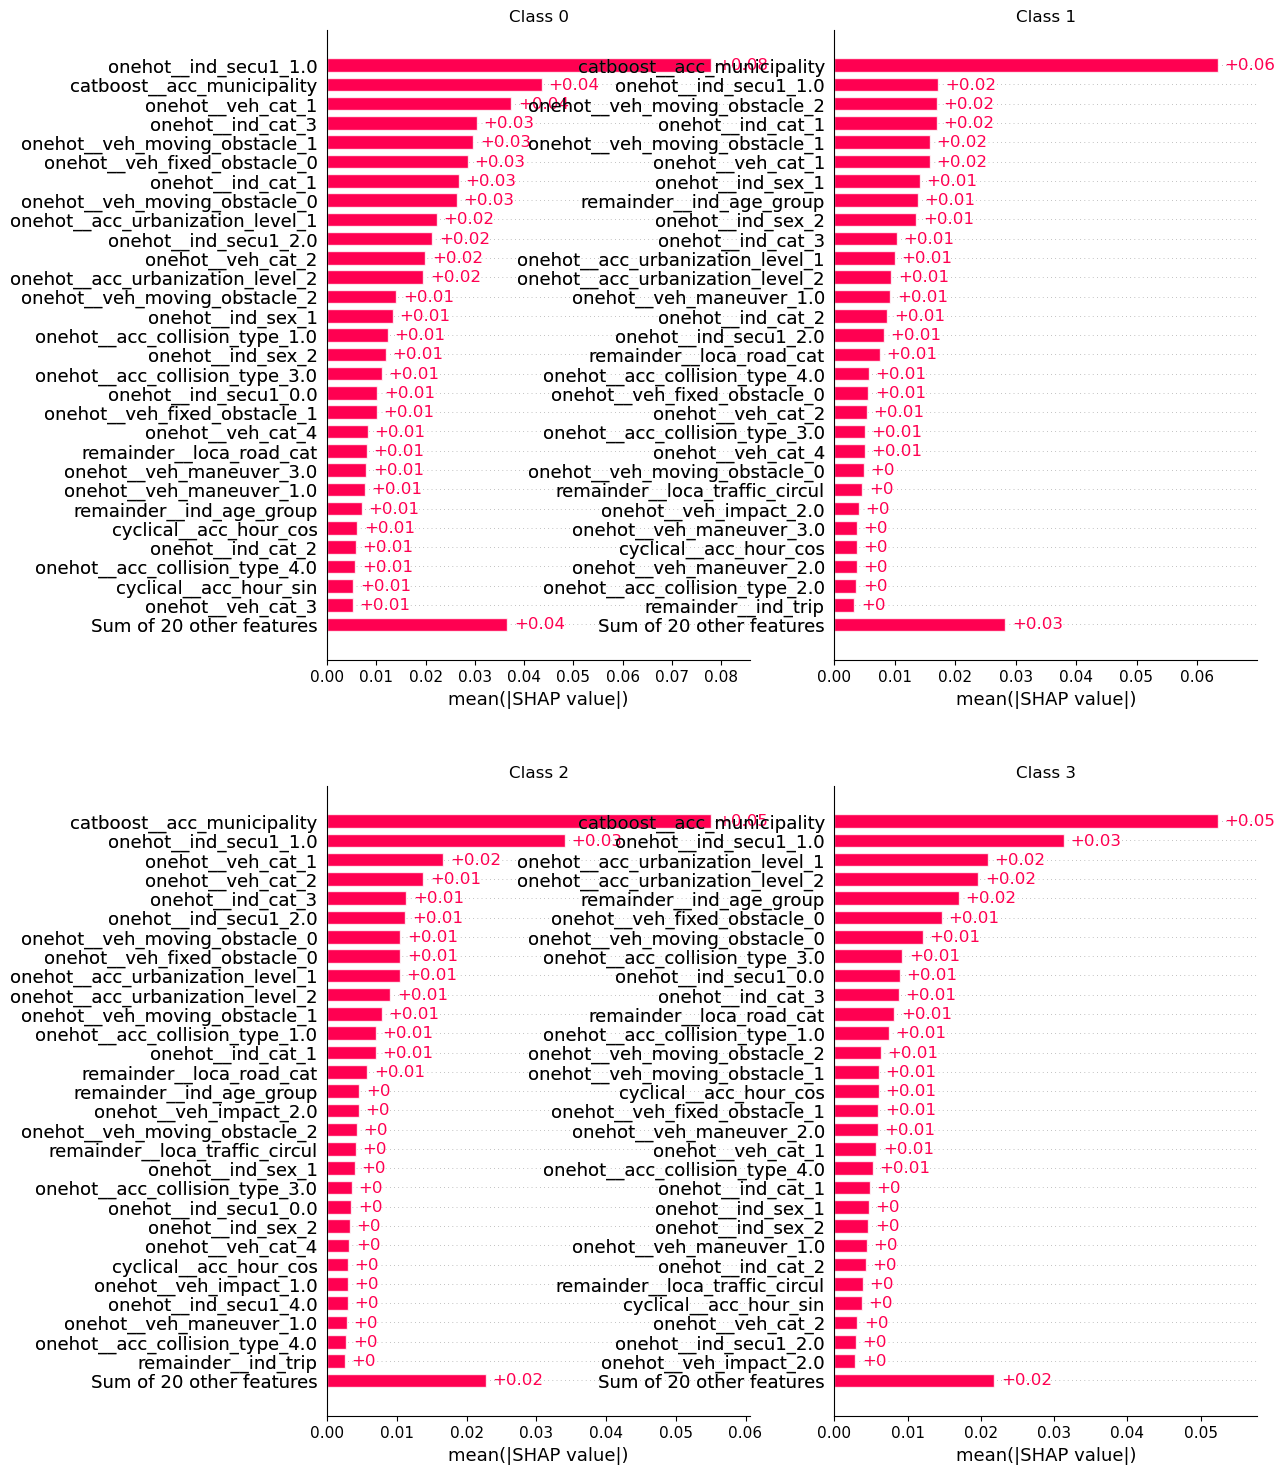

In [55]:
# ------------------------------------------------------------------------------- 
# bar plot per class for aggreated features 
# -------------------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 18))
axes = axes.flatten()

for c in range(shap_values.values.shape[-1]):
    shap.plots.bar(shap_values[:, :, c], max_display=30, show=False, ax=axes[c])
    axes[c].set_title(f"Class {c}")

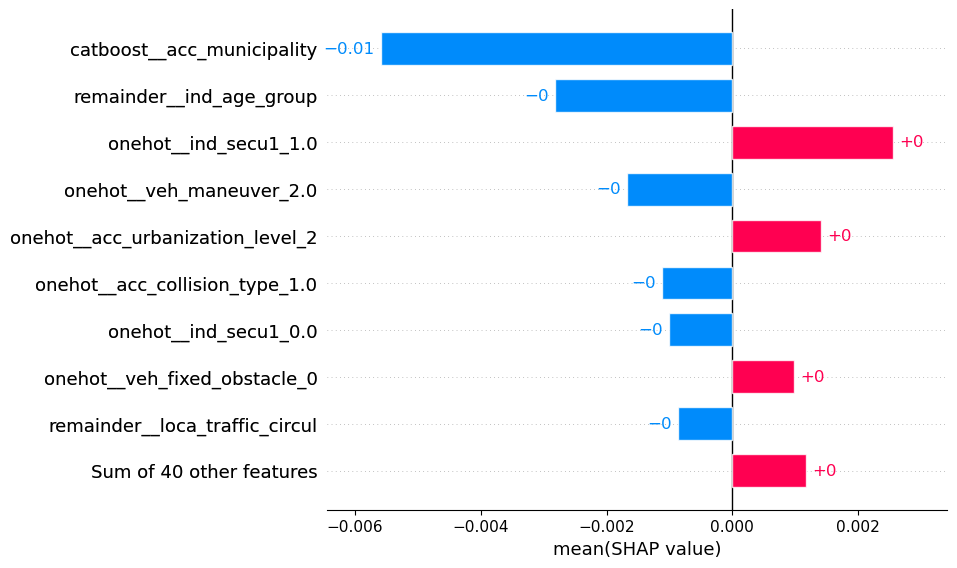

In [56]:
# ------------------------------------------------------------------------------- 
# bar plot for single class with mean impact 
# -------------------------------------------------------------------------------
shap.plots.bar(shap_values[:, :, 3].mean(0))

In [47]:
# ------------------------------------------------------------------------------- 
# check architecture of SHAP object
# -------------------------------------------------------------------------------
print(type(shap_values), end="\n\n")          # shap._explanation.Explanation
print(shap_values.shape, end="\n\n")          # (n_samples, n_classes, n_features) for multiclass
print(shap_values.values.shape, end="\n\n")   # same as above, the raw SHAP values
print(shap_values.base_values, end="\n\n")    # expected value(s) for each output
print(shap_values.data, end="\n\n")           # the input data (X_sub_clean) used
print(shap_values.feature_names, end="\n\n")  # feature names if you passed a DataFrame


<class 'shap._explanation.Explanation'>

(5000, 49, 4)

(5000, 49, 4)

[[0.37856319 0.27919744 0.18757902 0.15466035]
 [0.37856319 0.27919744 0.18757902 0.15466035]
 [0.37856319 0.27919744 0.18757902 0.15466035]
 ...
 [0.37856319 0.27919744 0.18757902 0.15466035]
 [0.37856319 0.27919744 0.18757902 0.15466035]
 [0.37856319 0.27919744 0.18757902 0.15466035]]

[[-5.00000000e-01  8.66025404e-01  5.00000000e-01 ...  2.00000000e+00
   1.00000000e+00  4.00000000e+00]
 [-8.66025404e-01 -5.00000000e-01  1.22464680e-16 ...  3.00000000e+00
   4.00000000e+00  2.00000000e+00]
 [-9.65925826e-01  2.58819045e-01 -5.00000000e-01 ...  3.00000000e+00
   5.00000000e+00  3.00000000e+00]
 ...
 [ 8.66025404e-01 -5.00000000e-01 -5.00000000e-01 ...  2.00000000e+00
   1.00000000e+00  3.00000000e+00]
 [-5.00000000e-01 -8.66025404e-01  5.00000000e-01 ...  5.00000000e+00
   2.00000000e+00  2.00000000e+00]
 [ 2.58819045e-01 -9.65925826e-01 -8.66025404e-01 ...  4.00000000e+00
   4.00000000e+00  3.00000000e+00]]

['c

In [57]:
# -------------------------------------------------------------------------------------------------------------------------------------
# table with shap impact classification per feature and class
# -------------------------------------------------------------------------------------------------------------------------------------
values = shap_values.values
n_classes = values.shape[2]

df_shap = pd.DataFrame(index=feature_names)

for c in range(n_classes):
    abs_vals = np.abs(values[:, :, c])
    mean_abs = abs_vals.mean(axis=0)        # average magnitude
    spread = abs_vals.std(axis=0)           # "dot-line length"
    
    # Thresholds for classification
    low_thr, high_thr = np.percentile(spread, [33, 66])
    labels = pd.cut(
        spread,
        bins=[-np.inf, low_thr, high_thr, np.inf],
        labels=["low", "medium", "high"]
    )
    
    # Add numeric + label columns
    df_shap[f"class_{c}_mean"] = mean_abs
    df_shap[f"class_{c}_spread"] = spread
    df_shap[f"class_{c}_impact"] = labels

# Current columns look like: class_0_mean, class_0_spread, class_0_impact, class_1_mean, ...
cols = df_shap.columns

# Group by suffix
impact_cols = [c for c in cols if c.endswith("_impact")]
mean_cols   = [c for c in cols if c.endswith("_mean")]
spread_cols = [c for c in cols if c.endswith("_spread")]

# New order: impacts first, then means, then spreads
new_order = impact_cols + mean_cols + spread_cols

df_shap_reordered = df_shap[new_order]

# Inspect
pd.set_option("display.max_rows", 170)
df_shap_reordered

,class_0_impact,class_1_impact,class_2_impact,class_3_impact,class_0_mean,class_1_mean,class_2_mean,class_3_mean,class_0_spread,class_1_spread,class_2_spread,class_3_spread
cyclical__acc_hour_sin,medium,low,medium,medium,0.005319,0.002602,0.002232,0.003722,0.004568,0.002696,0.002348,0.003111
cyclical__acc_hour_cos,medium,medium,medium,high,0.006117,0.003678,0.002975,0.006020,0.005717,0.004167,0.003098,0.005753
cyclical__acc_month_sin,low,low,low,low,0.001894,0.002241,0.001457,0.001146,0.001905,0.002045,0.001526,0.001266
cyclical__acc_month_cos,low,low,low,low,0.003471,0.002592,0.001793,0.002537,0.003041,0.002214,0.001926,0.002362
onehot__acc_urbanization_level_1,high,high,high,high,0.022263,0.010018,0.010380,0.020979,0.012457,0.007623,0.005792,0.009540
onehot__acc_urbanization_level_2,medium,medium,medium,high,0.019518,0.009403,0.009057,0.019635,0.011033,0.007387,0.005115,0.009274
onehot__acc_collision_type_1.0,high,medium,high,high,0.012308,0.003065,0.007015,0.007455,0.013968,0.004552,0.008261,0.008725
onehot__acc_collision_type_2.0,low,medium,medium,low,0.002089,0.003634,0.002184,0.001893,0.003312,0.004747,0.002881,0.003088
onehot__acc_collision_type_3.0,medium,medium,medium,high,0.011139,0.005033,0.003499,0.009279,0.009431,0.004802,0.003323,0.007018
onehot__acc_collision_type_4.0,medium,medium,medium,medium,0.005711,0.005672,0.002757,0.005225,0.005749,0.004661,0.002754,0.005099
